# RNN - Model

In [649]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
# from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [650]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [721]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [722]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [723]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

### Drop features with more than 30% NaN values

In [724]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)

In [725]:
df.shape

(5813, 65)

### Drop features with std = 0

In [726]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

In [727]:
df.shape

(5813, 41)

### Drop corrected features

In [728]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

### Drop choke features

In [729]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

### Drop correlated features

In [730]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

### Drop features in remove dictionary

In [731]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}

In [732]:
df.drop(columns=remove, inplace=True)

### Drop the Date

In [733]:
df.drop(columns='Date', inplace=True)

## Impute features with <30% NaN values

In [734]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [735]:
df.isnull().sum()

WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

In [736]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = 3 

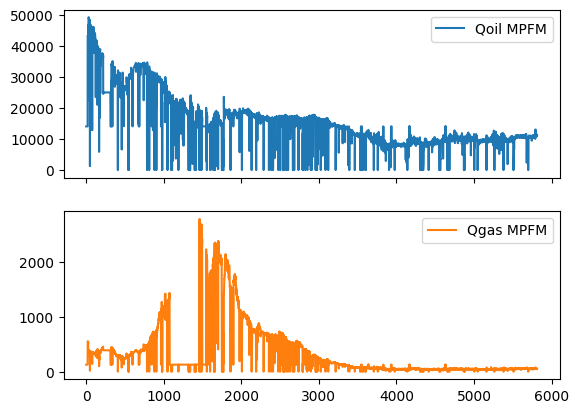

In [737]:
plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

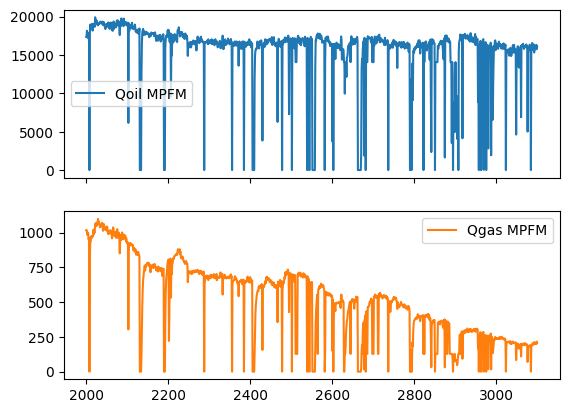

In [738]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [21]:
df_LSTM = df[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
df_LSTM

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
5808,1687.935181,51.966740,10925.670806
5809,1719.284912,51.968021,11142.564473
5810,1742.380127,51.972717,11140.120568
5811,1729.632324,51.982071,11400.139595


In [22]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 6 # six years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [23]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [24]:
folds = get_folds(df_LSTM, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 40 folds.
Each fold has a shape equal to (2190, 3).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [739]:
fold = folds[0]
fold

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
2185,4440.488770,50.234428,17033.866361
2186,4339.430664,50.448097,17049.719495
2187,4462.657715,50.312836,17144.442110
2188,4526.409668,50.242947,17705.125916


Split the fold above chronologically into a train dataframe and a test dataframe

In [740]:
INPUT_LENGTH = 14 #two weeks

In [741]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [742]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [743]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 3
INPUT_LENGTH = 14 days = 2 weeks


In [744]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [745]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    random_number = np.random.randint(0,len(fold) - (input_length + output_length) + 1)

    X_i = fold.iloc[random_number : random_number + input_length]
    y_i = fold.iloc[random_number + input_length : random_number + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [746]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [747]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [748]:
X_train_i.shape

(14, 3)

### Scanning chronologically

Let's scan the fold with a temporal stride of 1 day (the minimum one)

In [749]:
SEQUENCE_STRIDE = 1

In [750]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [751]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2190 days
= 312 weeks


In [752]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1430, 14, 3)
(1430, 1, 1)


## Modeling

### LSTM

Create a function init_model which builds and compiles a simple Recurrent Neural Network with an LSTM layer

In [753]:
X_train.shape

(1430, 14, 3)

In [754]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import EarlyStopping

In [755]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

#### Baseline model

In [42]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [43]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} m3")

24/24 [==============================] - 0s 309us/step - loss: 276075424.0000 - mae: 15974.0498
- The Baseline MAE on the test set is equal to 15974.05 m3


2023-03-21 11:11:47.792548: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Initial model from Weather prediction challenge but with batch_size=8 and epochs=150

In [44]:
def init_model(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [45]:
model_init = init_model(X_train, y_train)
model_init.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 3)          7         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,480
Trainable params: 17,473
Non-trainable params: 7
_________________________________________________________________


In [46]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model: models, verbose=1) -> tuple[models, dict]:
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [47]:
model_init, history_init = fit_model(model_init)

Epoch 1/150
125/125 [==============================] - 1s 4ms/step - loss: 996313408.0000 - mae: 30745.4062 - val_loss: 365563488.0000 - val_mae: 17611.6855
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 987532544.0000 - mae: 30604.7031 - val_loss: 360531840.0000 - val_mae: 17499.8145
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 978796608.0000 - mae: 30464.4746 - val_loss: 355577312.0000 - val_mae: 17386.8828
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 970140480.0000 - mae: 30324.8926 - val_loss: 350683488.0000 - val_mae: 17274.4707
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 961557184.0000 - mae: 30185.8320 - val_loss: 345845312.0000 - val_mae: 17162.4238
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 953039680.0000 - mae: 30047.1797 - val_loss: 341060000.0000 - val_mae: 17050.6758
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 2ms/step - loss: 607021376.0000 - mae: 23737.3359 - val_loss: 164965664.0000 - val_mae: 12080.8896
Epoch 54/150
125/125 [==============================] - 0s 2ms/step - loss: 600672448.0000 - mae: 23605.8184 - val_loss: 162170256.0000 - val_mae: 11981.0625
Epoch 55/150
125/125 [==============================] - 0s 2ms/step - loss: 594363456.0000 - mae: 23474.3574 - val_loss: 159412944.0000 - val_mae: 11881.2939
Epoch 56/150
125/125 [==============================] - 0s 2ms/step - loss: 588094400.0000 - mae: 23342.9902 - val_loss: 156693408.0000 - val_mae: 11781.5801
Epoch 57/150
125/125 [==============================] - 0s 2ms/step - loss: 581865280.0000 - mae: 23211.6836 - val_loss: 154011936.0000 - val_mae: 11682.0908
Epoch 58/150
125/125 [==============================] - 0s 2ms/step - loss: 575676352.0000 - mae: 23080.4688 - val_loss: 151368256.0000 - val_mae: 11584.1387
Epoch 59/150
125/125 [==============================

125/125 [==============================] - 0s 2ms/step - loss: 329222496.0000 - mae: 17023.2676 - val_loss: 68765816.0000 - val_mae: 7416.6616
Epoch 106/150
125/125 [==============================] - 0s 2ms/step - loss: 324913536.0000 - mae: 16903.6855 - val_loss: 67869112.0000 - val_mae: 7344.4277
Epoch 107/150
125/125 [==============================] - 0s 2ms/step - loss: 320642848.0000 - mae: 16784.2285 - val_loss: 67006972.0000 - val_mae: 7273.3501
Epoch 108/150
125/125 [==============================] - 0s 2ms/step - loss: 316410848.0000 - mae: 16665.1348 - val_loss: 66179304.0000 - val_mae: 7202.4546
Epoch 109/150
125/125 [==============================] - 0s 2ms/step - loss: 312216864.0000 - mae: 16546.2148 - val_loss: 65385972.0000 - val_mae: 7132.1626
Epoch 110/150
125/125 [==============================] - 0s 2ms/step - loss: 308061568.0000 - mae: 16427.4297 - val_loss: 64626908.0000 - val_mae: 7062.3691
Epoch 111/150
125/125 [==============================] - 0s 2ms/step - l

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

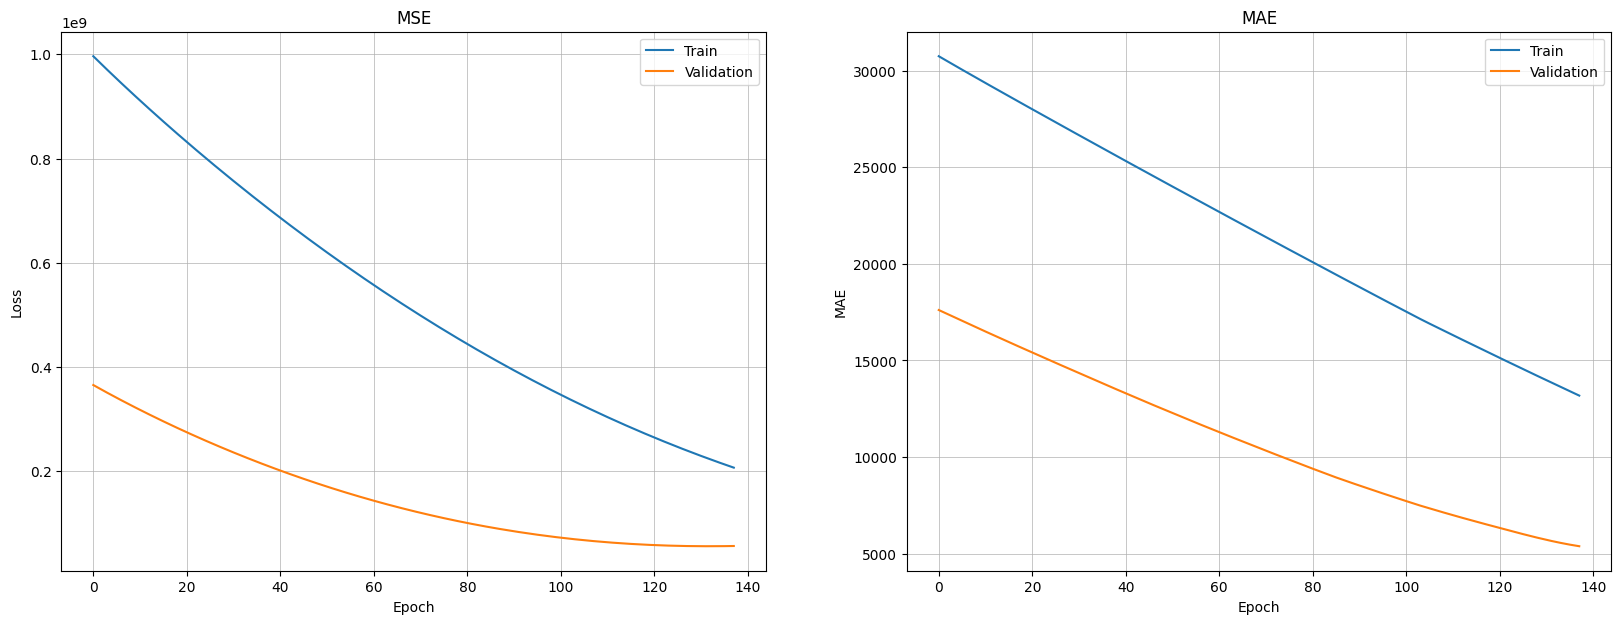

In [48]:
plot_history(history_init)

In [49]:
res = model_init.evaluate(X_test, y_test, verbose=0)
res

[24085236.0, 2532.921142578125]

In [50]:
mae_results = {}

In [51]:
mae_results['res'] = res[1]

#### Initial model with LSTM 128 neurons

In [52]:
def init_model_2(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [53]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [54]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [55]:
model_2, history_2 = fit_model(model_2)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 994699968.0000 - mae: 30718.7070 - val_loss: 363722848.0000 - val_mae: 17568.8105
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 982371136.0000 - mae: 30520.9258 - val_loss: 356505600.0000 - val_mae: 17408.5664
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 970020992.0000 - mae: 30321.9766 - val_loss: 349560512.0000 - val_mae: 17249.1055
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 957874112.0000 - mae: 30124.9668 - val_loss: 342737440.0000 - val_mae: 17090.5957
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 945644096.0000 - mae: 29925.1387 - val_loss: 335765664.0000 - val_mae: 16926.7344
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 933394048.0000 - mae: 29723.8008 - val_loss: 329008448.0000 - val_mae: 16766.8340
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 3ms/step - loss: 469875136.0000 - mae: 20702.3809 - val_loss: 109301880.0000 - val_mae: 9819.2158
Epoch 54/150
125/125 [==============================] - 0s 3ms/step - loss: 462089344.0000 - mae: 20516.1914 - val_loss: 106563480.0000 - val_mae: 9685.3906
Epoch 55/150
125/125 [==============================] - 0s 3ms/step - loss: 454386848.0000 - mae: 20330.2598 - val_loss: 103901976.0000 - val_mae: 9552.8311
Epoch 56/150
125/125 [==============================] - 0s 3ms/step - loss: 446767328.0000 - mae: 20144.5664 - val_loss: 101317456.0000 - val_mae: 9421.1748
Epoch 57/150
125/125 [==============================] - 0s 3ms/step - loss: 439230784.0000 - mae: 19959.1230 - val_loss: 98807456.0000 - val_mae: 9290.3359
Epoch 58/150
125/125 [==============================] - 0s 3ms/step - loss: 431776096.0000 - mae: 19773.9316 - val_loss: 96370840.0000 - val_mae: 9159.7178
Epoch 59/150
125/125 [==============================] - 0s 3

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

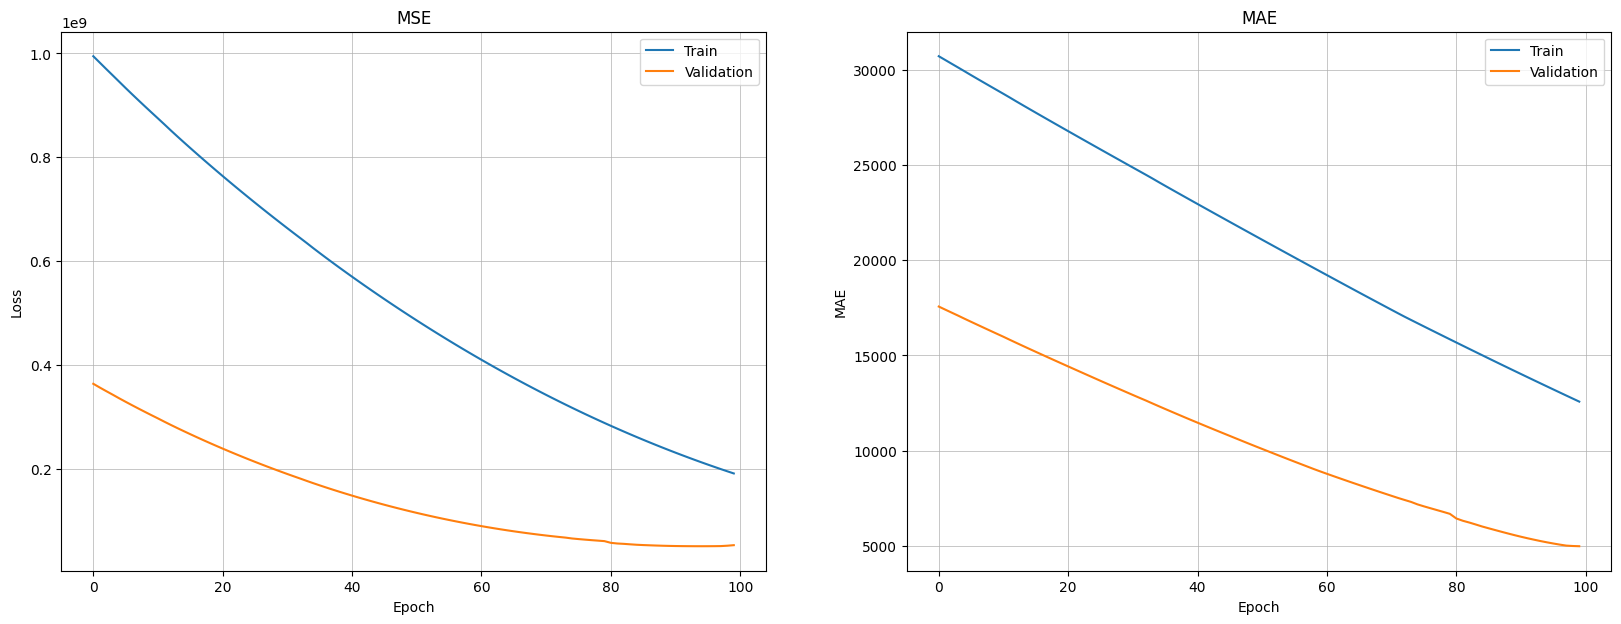

In [57]:
plot_history(history_2)

In [58]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[23976738.0, 2594.729736328125]

In [59]:
mae_results['res2'] = res2[1]

#### Initial model but with one more LSTM layer

In [65]:
def init_model_3(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [66]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         67584     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 117,064
Trainable params: 117,057
Non-trainable params: 7
________________________________________________

In [67]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [69]:
model_3, history_3 = fit_model(model_3)

Epoch 1/150
125/125 [==============================] - 2s 6ms/step - loss: 996500544.0000 - mae: 30748.3438 - val_loss: 366612608.0000 - val_mae: 17636.3867
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 988614592.0000 - mae: 30622.2402 - val_loss: 362564928.0000 - val_mae: 17544.2598
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 980709696.0000 - mae: 30495.4688 - val_loss: 358563168.0000 - val_mae: 17453.2188
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 972843776.0000 - mae: 30368.7695 - val_loss: 354634048.0000 - val_mae: 17362.2988
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 965020672.0000 - mae: 30242.2305 - val_loss: 350778400.0000 - val_mae: 17273.8574
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 957243072.0000 - mae: 30115.8926 - val_loss: 346900480.0000 - val_mae: 17183.0371
Epoch 7/150
125/125 [==============================] - 1s 

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 634638592.0000 - mae: 24301.0684 - val_loss: 181166096.0000 - val_mae: 12534.6602
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 628496256.0000 - mae: 24176.9043 - val_loss: 178330448.0000 - val_mae: 12438.9141
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 622400128.0000 - mae: 24053.0273 - val_loss: 175301296.0000 - val_mae: 12338.2148
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 616346688.0000 - mae: 23929.3594 - val_loss: 171688608.0000 - val_mae: 12232.8066
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 610334080.0000 - mae: 23805.8672 - val_loss: 168442320.0000 - val_mae: 12154.3037
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 604361408.0000 - mae: 23682.5293 - val_loss: 165547552.0000 - val_mae: 12081.0244
Epoch 59/150
125/125 [==============================

125/125 [==============================] - 1s 6ms/step - loss: 363500704.0000 - mae: 17988.6055 - val_loss: 77502968.0000 - val_mae: 8094.5039
Epoch 106/150
125/125 [==============================] - 1s 6ms/step - loss: 359197120.0000 - mae: 17870.0957 - val_loss: 76415912.0000 - val_mae: 8021.7192
Epoch 107/150
125/125 [==============================] - 1s 6ms/step - loss: 354927072.0000 - mae: 17751.6816 - val_loss: 75309328.0000 - val_mae: 7945.9536
Epoch 108/150
125/125 [==============================] - 1s 6ms/step - loss: 350690848.0000 - mae: 17633.3906 - val_loss: 74292344.0000 - val_mae: 7875.1372
Epoch 109/150
125/125 [==============================] - 1s 6ms/step - loss: 346488320.0000 - mae: 17515.2051 - val_loss: 73190208.0000 - val_mae: 7795.0757
Epoch 110/150
125/125 [==============================] - 1s 6ms/step - loss: 342319360.0000 - mae: 17397.1289 - val_loss: 72024032.0000 - val_mae: 7708.4360
Epoch 111/150
125/125 [==============================] - 1s 6ms/step - l

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

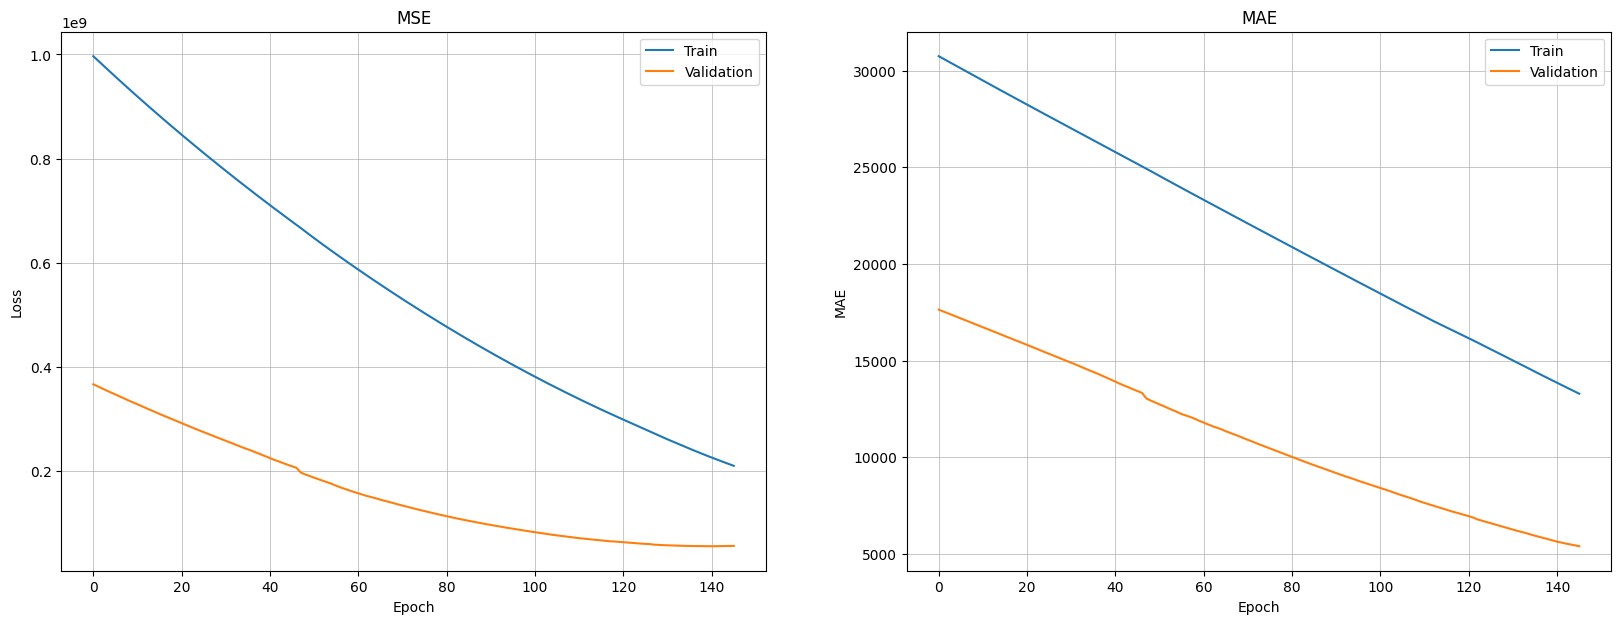

In [70]:
plot_history(history_3)

In [71]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[23145874.0, 2493.5693359375]

In [72]:
mae_results['res3'] = res3[1]

In [74]:
print(mae_results)

{'res': 2532.921142578125, 'res2': 2594.729736328125, 'res3': 2493.5693359375}


#### Add more layers

In [139]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(64, activation='tanh'))
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [140]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_16 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_27 (LSTM)              (None, None, 128)         67584     
                                                                 
 dropout_17 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_28 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                     

In [141]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [142]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 2s 8ms/step - loss: 996015360.0000 - mae: 30740.3926 - val_loss: 366413056.0000 - val_mae: 17632.4668
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 987458240.0000 - mae: 30603.4297 - val_loss: 362300544.0000 - val_mae: 17540.7383
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 978782208.0000 - mae: 30464.1367 - val_loss: 356968160.0000 - val_mae: 17417.1797
Epoch 4/150
125/125 [==============================] - 1s 6ms/step - loss: 970030784.0000 - mae: 30323.0938 - val_loss: 351916704.0000 - val_mae: 17301.2168
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 961208640.0000 - mae: 30179.9648 - val_loss: 347217120.0000 - val_mae: 17192.5547
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 952266112.0000 - mae: 30034.3047 - val_loss: 342590432.0000 - val_mae: 17084.4668
Epoch 7/150
125/125 [==============================] - 1s 

Epoch 53/150
125/125 [==============================] - 1s 6ms/step - loss: 596295168.0000 - mae: 23511.0391 - val_loss: 161080480.0000 - val_mae: 11939.2910
Epoch 54/150
125/125 [==============================] - 1s 6ms/step - loss: 590699968.0000 - mae: 23394.4727 - val_loss: 158196576.0000 - val_mae: 11834.4961
Epoch 55/150
125/125 [==============================] - 1s 6ms/step - loss: 583828352.0000 - mae: 23251.4805 - val_loss: 155342208.0000 - val_mae: 11729.3857
Epoch 56/150
125/125 [==============================] - 1s 6ms/step - loss: 576717376.0000 - mae: 23098.2129 - val_loss: 152523984.0000 - val_mae: 11625.5322
Epoch 57/150
125/125 [==============================] - 1s 6ms/step - loss: 570873216.0000 - mae: 22975.0215 - val_loss: 149712640.0000 - val_mae: 11521.0410
Epoch 58/150
125/125 [==============================] - 1s 6ms/step - loss: 563655168.0000 - mae: 22820.2500 - val_loss: 146992672.0000 - val_mae: 11418.2266
Epoch 59/150
125/125 [==============================

125/125 [==============================] - 1s 6ms/step - loss: 313070912.0000 - mae: 16564.2031 - val_loss: 65478984.0000 - val_mae: 7140.5518
Epoch 106/150
125/125 [==============================] - 1s 6ms/step - loss: 308892032.0000 - mae: 16447.9648 - val_loss: 64685236.0000 - val_mae: 7067.8193
Epoch 107/150
125/125 [==============================] - 1s 6ms/step - loss: 305238752.0000 - mae: 16338.7588 - val_loss: 63928348.0000 - val_mae: 6995.7725
Epoch 108/150
125/125 [==============================] - 1s 6ms/step - loss: 300061504.0000 - mae: 16183.6904 - val_loss: 63208196.0000 - val_mae: 6924.5542
Epoch 109/150
125/125 [==============================] - 1s 6ms/step - loss: 295409504.0000 - mae: 16050.7852 - val_loss: 62524240.0000 - val_mae: 6853.8271
Epoch 110/150
125/125 [==============================] - 1s 6ms/step - loss: 292995040.0000 - mae: 15970.9160 - val_loss: 61878204.0000 - val_mae: 6783.7769
Epoch 111/150
125/125 [==============================] - 1s 6ms/step - l

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

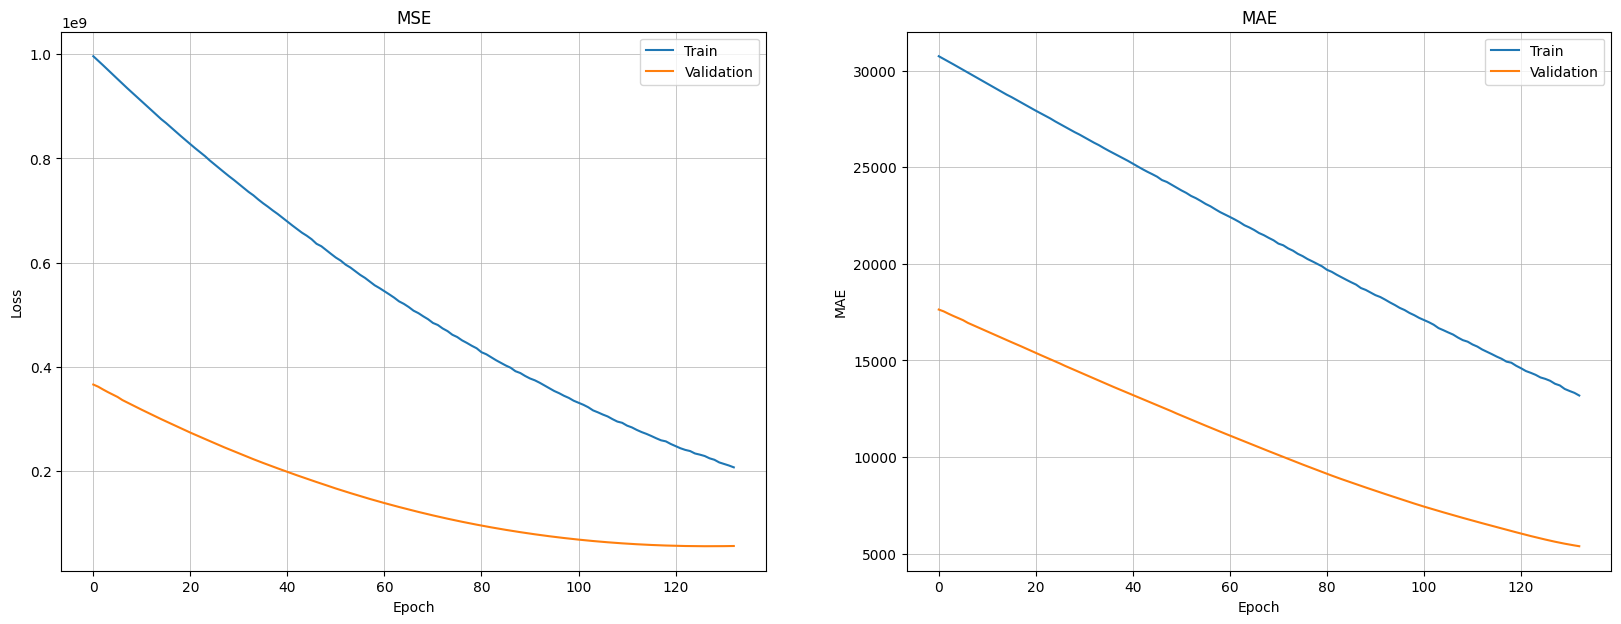

In [143]:
plot_history(history_4)

In [144]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[23962748.0, 2531.59814453125]

In [145]:
mae_results['res4'] = res4[1]

In [146]:
mae_results

{'res': 2532.921142578125,
 'res2': 2594.729736328125,
 'res3': 2493.5693359375,
 'res4': 2531.59814453125}

#### Test with more features

In [202]:
df[['MPFM Venturi dP', 'WHT', 'Tubing Gradient']]

,MPFM Venturi dP,WHT,Tubing Gradient
0,1672.997986,51.247467,0.000000
1,1672.997986,51.247467,0.000000
2,1672.997986,51.247467,0.000000
3,1672.997986,51.247467,0.000000
4,1672.997986,51.247467,0.000000
...,...,...,...
5808,1687.935181,51.966740,1.003753
5809,1719.284912,51.968021,1.003906
5810,1742.380127,51.972717,1.005642
5811,1729.632324,51.982071,1.006597


In [296]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.15)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [297]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_50 (LSTM)              (None, 128)               67584     
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [298]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [299]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 964556736.0000 - mae: 30215.6406 - val_loss: 327854688.0000 - val_mae: 16739.6250
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 888815744.0000 - mae: 28958.2363 - val_loss: 287320896.0000 - val_mae: 15736.3643
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 816949440.0000 - mae: 27715.8789 - val_loss: 250696144.0000 - val_mae: 14758.2383
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 750925632.0000 - mae: 26525.0508 - val_loss: 222630672.0000 - val_mae: 13856.2500
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 685689728.0000 - mae: 25276.5391 - val_loss: 185955088.0000 - val_mae: 12695.2217
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 615159552.0000 - mae: 23872.2168 - val_loss: 155759152.0000 - val_mae: 11630.9375
Epoch 7/150
125/125 [==============================] - 0s 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

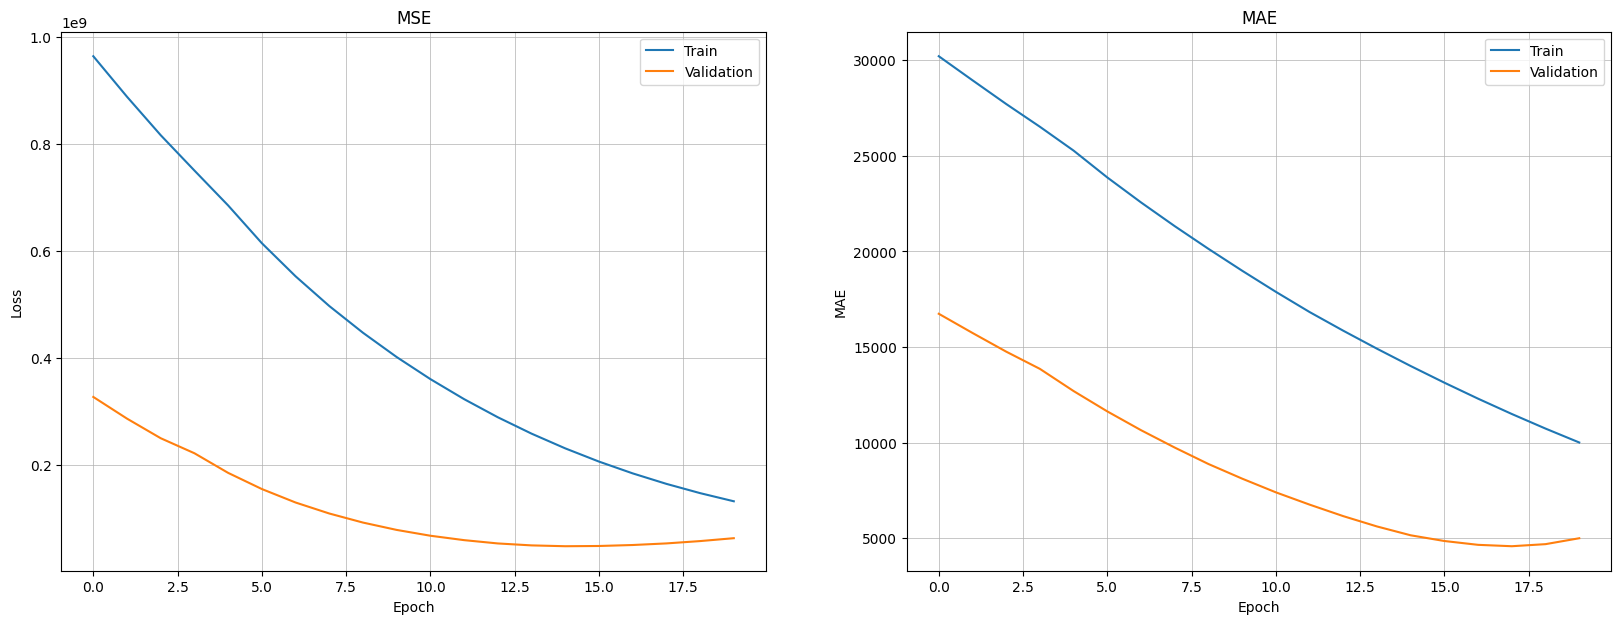

In [300]:
plot_history(history_4)

In [309]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[22892092.0, 2442.34619140625]

In [312]:
mae_results['res4'] = res4[1]

In [313]:
mae_results

{'res': 2532.921142578125,
 'res2': 2594.729736328125,
 'res3': 2493.5693359375,
 'res4': 2442.34619140625}

#### Applying a scaler to the df

In [565]:
FOLD_LENGTH

2190

In [566]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(df_LSTM)
df_LSTM_scaled = std_scaler.transform(df_LSTM)

In [567]:
df_LSTM_scaled = pd.DataFrame(df_LSTM_scaled, columns=df_LSTM.columns)

In [568]:
folds_longer = get_folds(df_LSTM_scaled, 365*3, FOLD_STRIDE)
fold_longer = folds_longer[0]
(fold_train_longer, fold_test_longer) = train_test_split(fold_longer, TRAIN_TEST_RATIO, INPUT_LENGTH)

X_train_c, y_train_c = get_X_y_strides(fold_train_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_c, y_test_c = get_X_y_strides(fold_test_longer, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_c.shape)
print(y_train_c.shape)

(708, 14, 3)
(708, 1, 1)


In [569]:
N_FEATURES

3

In [559]:
def init_model_5(X_train, y_train):
    
    #normalization
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    #model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', input_shape=(X_train_c.shape[1], X_train_c.shape[2])))
    model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [560]:
model_5 = init_model_5(X_train_c, y_train_c)
model_5.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 128)               67584     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [561]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor = "val_mae", mode = "min")

def fit_model(model):
    
    history = model.fit(X_train_c, y_train_c,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=250,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [562]:
model_5, history_5 = fit_model(model_5)

Epoch 1/250
62/62 [==============================] - 2s 7ms/step - loss: 0.9333 - mae: 0.6695 - val_loss: 0.6518 - val_mae: 0.7323
Epoch 2/250
62/62 [==============================] - 0s 4ms/step - loss: 1.0010 - mae: 0.7356 - val_loss: 0.3131 - val_mae: 0.4198
Epoch 3/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9121 - mae: 0.7171 - val_loss: 0.3013 - val_mae: 0.3857
Epoch 4/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8924 - mae: 0.7198 - val_loss: 0.3543 - val_mae: 0.4467
Epoch 5/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8647 - mae: 0.6832 - val_loss: 0.2928 - val_mae: 0.3871
Epoch 6/250
62/62 [==============================] - 0s 4ms/step - loss: 0.8888 - mae: 0.6834 - val_loss: 0.3434 - val_mae: 0.4574
Epoch 7/250
62/62 [==============================] - 0s 4ms/step - loss: 0.7312 - mae: 0.6160 - val_loss: 0.5694 - val_mae: 0.6840
Epoch 8/250
62/62 [==============================] - 0s 4ms/step - loss: 0.9909 - m

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

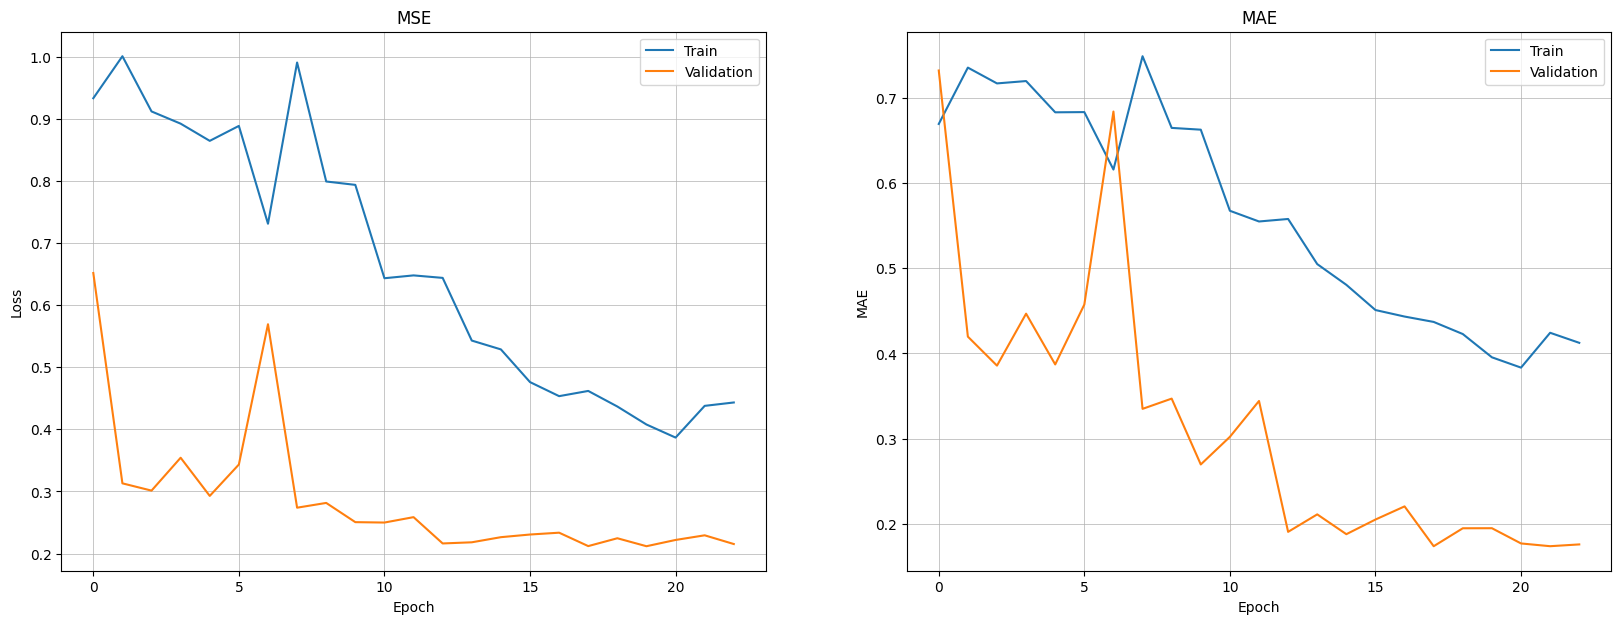

In [563]:
plot_history(history_5)

In [564]:
res5 = model_5.evaluate(X_test_c, y_test_c, verbose=0)
res5

[0.5426031947135925, 0.49569591879844666]

In [550]:
predicted_values = pd.DataFrame(model_5.predict(X_test_c))


12/12 [==============================] - 0s 989us/step


In [552]:
pd.DataFrame(y_test_c)

ValueError: Must pass 2-d input. shape=(371, 1, 1)

#### Changing the fold length

In [663]:
df

,Date,WHT,WHP,Tubing Gradient,Service Line P,Sand Raw,Qoil MPFM,Qgas MPFM,MPFM WCT,MPFM Venturi dP,MPFM T,MPFM CF GOR,Manifold T,Manifold P,Jumper T,Choke Opening,Annulus P
0,2007-02-01,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
1,2007-02-02,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
2,2007-02-03,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
3,2007-02-04,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
4,2007-02-05,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5808,2022-12-27,51.966740,65.511459,1.003753,94.382515,8766.217773,10925.670806,55.476961,66.457010,1687.935181,52.973598,1.75,54.094212,56.295765,52.052349,72.995338,147.032196
5809,2022-12-28,51.968021,65.433243,1.003906,94.655754,8263.583984,11142.564473,54.175189,65.386773,1719.284912,52.985542,1.75,54.080822,56.066448,52.066982,72.484528,147.082047
5810,2022-12-29,51.972717,65.115013,1.005642,94.524742,8157.360352,11140.120568,52.403613,65.647569,1742.380127,52.981174,1.75,54.060078,55.621841,52.061150,73.002724,147.067032
5811,2022-12-30,51.982071,64.796227,1.006597,94.201897,8184.041992,11400.139595,53.583697,64.967486,1729.632324,52.975830,1.75,54.038525,55.262222,52.074127,72.730721,147.128189


In [666]:
X_train = df_train[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
y_train = df_train['Qoil MPFM']
X_val = df_val[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
y_val = df_val['Qoil MPFM']
X_test = df_test[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
y_test = df_test['Qoil MPFM']

In [764]:
INPUT_LENGTH

14

In [756]:
folds_shorter = get_folds(df_LSTM, 365*4, FOLD_STRIDE)
fold_shorter = folds_shorter[2]
(fold_train_shorter, fold_test_shorter) = train_test_split(fold_shorter, TRAIN_TEST_RATIO, INPUT_LENGTH)

X_train_s, y_train_s = get_X_y_strides(fold_train_shorter, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_s, y_test_s = get_X_y_strides(fold_test_shorter, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_s.shape)
print(y_train_s.shape)

(828, 14, 3)
(828, 1, 1)


In [757]:
def init_model_6(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh'))
    model.add(layers.Dropout(rate=0.3))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.05)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [758]:
model_6 = init_model_6(X_train_s, y_train_s)
model_6.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_91 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_110 (LSTM)             (None, 128)               67584     
                                                                 
 dropout_55 (Dropout)        (None, 128)               0         
                                                                 
 dense_97 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [759]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_mae', mode='min')

def fit_model(model):
    
    history = model.fit(X_train_s, y_train_s,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=250,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [760]:
model_6, history_6 = fit_model(model_6)

Epoch 1/250
73/73 [==============================] - 1s 7ms/step - loss: 874017728.0000 - mae: 29136.8730 - val_loss: 822662208.0000 - val_mae: 28135.4062
Epoch 2/250
73/73 [==============================] - 0s 4ms/step - loss: 852942528.0000 - mae: 28776.6484 - val_loss: 803353408.0000 - val_mae: 27810.5137
Epoch 3/250
73/73 [==============================] - 0s 4ms/step - loss: 833069632.0000 - mae: 28432.3906 - val_loss: 785247872.0000 - val_mae: 27497.9707
Epoch 4/250
73/73 [==============================] - 0s 4ms/step - loss: 813439488.0000 - mae: 28087.5234 - val_loss: 768637184.0000 - val_mae: 27213.2188
Epoch 5/250
73/73 [==============================] - 0s 4ms/step - loss: 793782272.0000 - mae: 27739.8438 - val_loss: 754718080.0000 - val_mae: 26979.1562
Epoch 6/250
73/73 [==============================] - 0s 4ms/step - loss: 775061440.0000 - mae: 27404.0840 - val_loss: 737697536.0000 - val_mae: 26669.3770
Epoch 7/250
73/73 [==============================] - 0s 4ms/step - los

73/73 [==============================] - 0s 4ms/step - loss: 199048016.0000 - mae: 13460.9365 - val_loss: 183107808.0000 - val_mae: 13260.3096
Epoch 54/250
73/73 [==============================] - 0s 4ms/step - loss: 195756672.0000 - mae: 13351.2373 - val_loss: 176715200.0000 - val_mae: 13020.5400
Epoch 55/250
73/73 [==============================] - 0s 4ms/step - loss: 190768128.0000 - mae: 13186.4658 - val_loss: 170487888.0000 - val_mae: 12781.8096
Epoch 56/250
73/73 [==============================] - 0s 4ms/step - loss: 183473920.0000 - mae: 12898.1680 - val_loss: 164432640.0000 - val_mae: 12544.4688
Epoch 57/250
73/73 [==============================] - 0s 4ms/step - loss: 178820608.0000 - mae: 12695.1367 - val_loss: 158538448.0000 - val_mae: 12310.0283
Epoch 58/250
73/73 [==============================] - 0s 4ms/step - loss: 171463072.0000 - mae: 12452.8262 - val_loss: 152819472.0000 - val_mae: 12077.4805
Epoch 59/250
73/73 [==============================] - 0s 4ms/step - loss: 164

73/73 [==============================] - 0s 4ms/step - loss: 33894844.0000 - mae: 4618.7300 - val_loss: 34439056.0000 - val_mae: 3865.9048
Epoch 107/250
73/73 [==============================] - 0s 4ms/step - loss: 33703100.0000 - mae: 4568.7031 - val_loss: 34098364.0000 - val_mae: 3772.1782
Epoch 108/250
73/73 [==============================] - 0s 4ms/step - loss: 32996478.0000 - mae: 4542.4160 - val_loss: 33811468.0000 - val_mae: 3689.5955
Epoch 109/250
73/73 [==============================] - 0s 4ms/step - loss: 31777136.0000 - mae: 4419.2910 - val_loss: 33561168.0000 - val_mae: 3612.4875
Epoch 110/250
73/73 [==============================] - 0s 4ms/step - loss: 32099620.0000 - mae: 4433.8594 - val_loss: 33324724.0000 - val_mae: 3534.1338
Epoch 111/250
73/73 [==============================] - 0s 4ms/step - loss: 33679652.0000 - mae: 4524.6816 - val_loss: 33111880.0000 - val_mae: 3457.6851
Epoch 112/250
73/73 [==============================] - 0s 4ms/step - loss: 30433514.0000 - mae: 

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

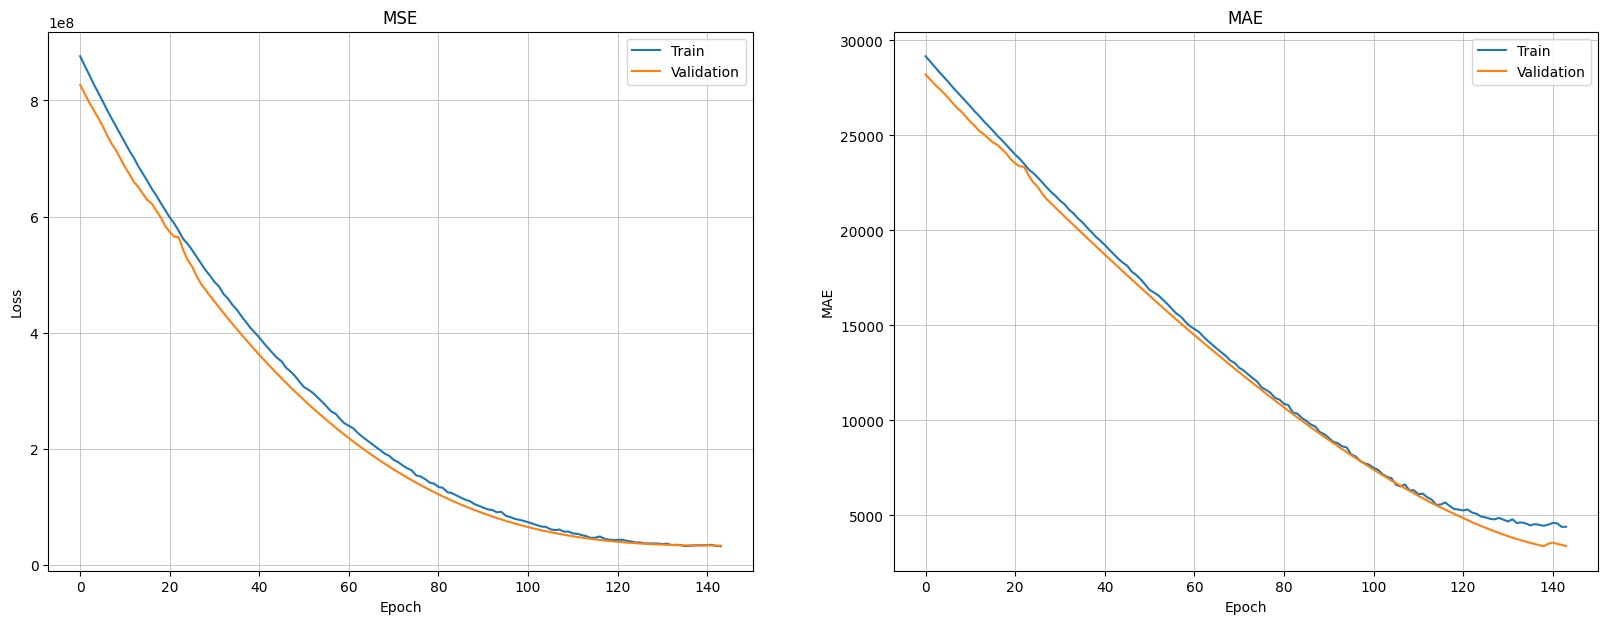

In [717]:
plot_history(history_6)

In [761]:
res6 = model_6.evaluate(X_test_s, y_test_s, verbose=0)
res6

[148285456.0, 9949.916015625]

<Axes: >

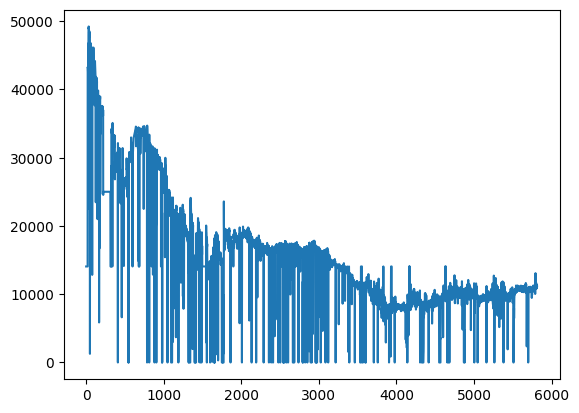

In [763]:
df['Qoil MPFM'].plot()

In [646]:
y_pred = model_6.predict(X_test_s)
df_pred = pd.DataFrame({'Actual': y_test_s.reshape(-1), 'Predicted': y_pred.reshape(-1)})

7/7 [==============================] - 0s 2ms/step


In [632]:
df_pred

,Actual,Predicted
0,33862.914617,30081.1875
1,33609.066392,30081.1875
2,33335.180913,30081.1875
3,33579.255822,30081.1875
4,33529.668281,30081.1875
...,...,...
366,23746.715277,30081.1875
367,23788.793743,30081.1875
368,23831.706038,30081.1875
369,22478.727202,30081.1875
